In [158]:
import pandas as pd
df = pd.read_csv('data/train.csv')
df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,29400.000000,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,...,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.0,29400.0,29400.0,29400.0,29400.0
mean,4.453810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.179592,0.111429,0.059762,0.021565,0.002449,0.0,0.0,0.0,0.0,0.0
std,2.882268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.691586,4.603814,3.291418,1.999050,0.318581,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,252.000000,253.000000,50.000000,0.0,0.0,0.0,0.0,0.0


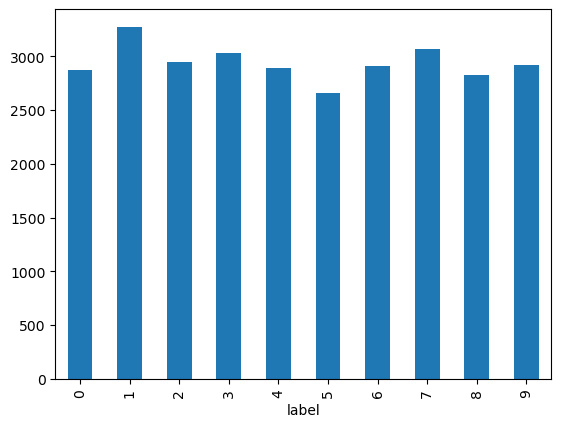

In [159]:
import matplotlib.pyplot as plt

label_data = df.groupby(by='label').size()
label_data.plot(kind='bar')
plt.show()

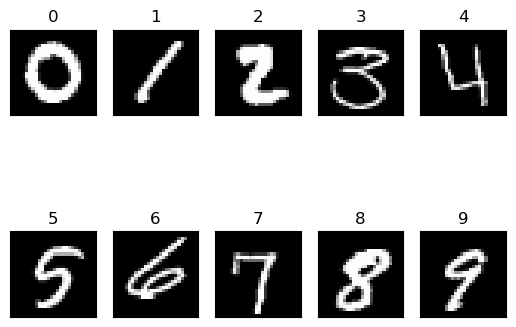

In [160]:
labels = df['label']
images = df.iloc[:, 1:].to_numpy()
images = images.reshape((len(images), 28, 28))

def plot_all(labels, images):
    fig, axs = plt.subplots(nrows=2, ncols=5)
    digits = set(i for i in range(10))
    index = 0

    while(len(digits) > 0):
        label = labels[index]
        pixels = images[index]

        if(label in digits):
            digits.remove(label)
            
            axs[label // 5, label % 5].imshow(pixels, cmap='gray', vmin=0, vmax=255)
            axs[label // 5, label % 5].set_title(label)
            axs[label // 5, label % 5].get_xaxis().set_visible(False)
            axs[label // 5, label % 5].get_yaxis().set_visible(False)

        index += 1

    plt.show()

plot_all(labels, images)

preprocessing

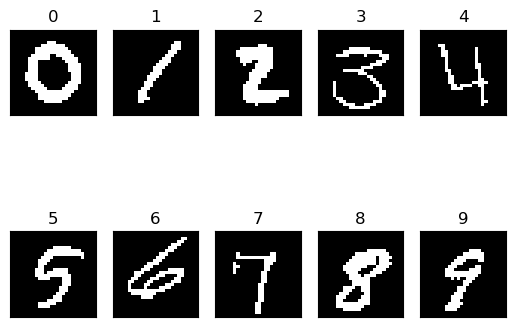

In [161]:
# BW
threshold = 128
images = (images > threshold).astype(int)

plot_all(labels, images * 255)

Next, we're going to augment our data (i.e. create new data from our existing data) by using image transformations. In particular, various studies have found elastic transformations to be particularly effective in the digit recognization task. An elastic transformation basically (locally) warps the image, making it look like the image has been refracted through water. Let's set up an elastic transformation and test it out.

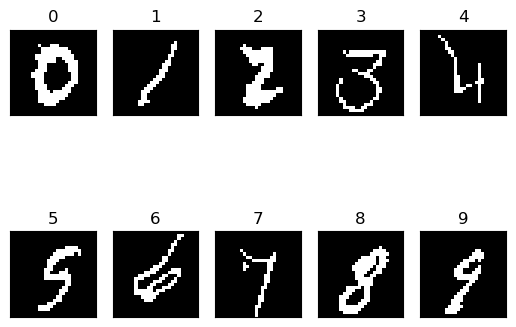

In [162]:
import torch
import numpy as np
from torchvision.transforms import ElasticTransform

# elastic deformation
transform = ElasticTransform(alpha=85.0)
images_elastic_transform = torch.Tensor(images)
images_elastic_transform = transform(images_elastic_transform)
images_elastic_transform = np.array(images_elastic_transform)
images_elastic_transform = (images_elastic_transform * 255 > threshold).astype(int)

# images = np.vstack((images, images_elastic_transform))

# plot_all(labels, images * 255)
plot_all(labels, images_elastic_transform * 255)

Note that we don't add the transformed images to the data just yet, because we don't want it to be included in our test data. We want our test data to reflect the actual dataset, so using augmented data defeats that purpose. Let's set up our model next.

In [182]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_1 = nn.Conv2d(1, 32, 5, padding='same')
        self.conv1_2 = nn.Conv2d(32, 32, 5, padding='same')
        self.conv2_1 = nn.Conv2d(32, 64, 3, padding='same')
        self.conv2_2 = nn.Conv2d(64, 64, 3, padding='same')
        
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x))
        return x
    
net = Net()

Training

In [164]:
import torch
from torch.utils.data import Dataset
# from torchvision import datasets
from torchvision.transforms import ToTensor
import os
import pandas as pd
from torchvision.io import read_image

class Digits(Dataset):
    def __init__(self, file, transform=None):
        self.data = pd.read_csv(file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item_data = self.data.iloc[idx]
        image = item_data.iloc[1:].to_numpy()
        image = image.reshape((28, 28))
        image = image / image.max()
        label = item_data.iloc[0]
        if self.transform:
            image = self.transform(image)
        image = image.float()
        return image, label

In [169]:
from torchvision import transforms
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.ElasticTransform(alpha=85.0)
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
])

trainset = Digits('data/train.csv', transform_train)
valset = Digits('data/val.csv', transform_val)

In [170]:
batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

In [183]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters())

In [184]:
epochs = 10
for epoch in range(epochs):  # loop over the dataset multiple times
    print(f"Epoch {epoch+1}")
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the val images: {100 * correct // total} %')

print('Finished Training')

Epoch 1


C:\Users\moomo\AppData\Local\Temp\ipykernel_23380\2591491760.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


[1,  2000] loss: 2.047
[1,  4000] loss: 1.891
[1,  6000] loss: 1.872
Accuracy of the network on the val images: 29 %
Epoch 2
[2,  2000] loss: 2.021
[2,  4000] loss: 1.947


KeyboardInterrupt: 

In [173]:
PATH = './digit_net.pth'
torch.save(net.state_dict(), PATH)

In [181]:
testset = Digits('data/test_with_id.csv', transform_val)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

import csv
submission_file = open("data/submission.csv", mode="w", newline="")
submission_writer = csv.writer(submission_file)
submission_writer.writerow(["ImageId", "Label"])
# submission_file.close()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        image, label = data
        # calculate outputs by running images through the network
        outputs = net(image)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        submission_writer.writerow([label.item(), predicted.item()])
submission_file.close()

C:\Users\moomo\AppData\Local\Temp\ipykernel_23380\3090948769.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))
